<a href="https://colab.research.google.com/github/engelsm/MLESS/blob/main/homework1/CNN_classifier_on_remote_sensing_image_WITH_RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN classifier for landcover classification from remote sensing images

In this tasks, we will again use the same portion of the [SAT-6](https://csc.lsu.edu/~saikat/deepsat/) dataset from Louisiana State University and NASA Ames Research Center.

In this notebook, we will make use of small CNN network on the same subset of SAT-6 dataset that we used in the last exercise

In [ ]:
# CNN classifier for landcover classification
# Author: Ankit Patnala, JSC, 2025
# Download necessary packages if right kernel is not present
# Not needed in colab
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Obtaining the data
The data is available via this B2share link [link](https://b2share.eudat.eu/records/89654eac10724d30a6c7e51f2c5422de). Download all the files at the same folder path where you are creating this notebook

Alternatively use the following wget commands to download the data

The following cell can be executed in Google colab

In [ ]:
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/sat6annotations.csv

--2025-05-13 09:20:03--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 905628829 (864M) [text/plain]
Saving to: ‘X_test_sat6.csv’

X_test_sat6.csv     100%[===================>] 863.67M  19.5MB/s    in 48s     

2025-05-13 09:20:52 (18.0 MB/s) - ‘X_test_sat6.csv’ saved [905628829/905628829]

--2025-05-13 09:20:53--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 972000 (949K) [text/plain]
Saving to: ‘y_test_sat6.csv’

y_test_sat6.csv     100%[===================>] 949.22K  1.07MB/s    in 0.9s    

2025-05-13 09:20

In [ ]:
# load the csv file with the image data. Each row belongs to one sample. Each sample has 3136 columns i.e. 4 channels (R,G,B, and NIR) and 28 \times 28 spatial size
landcover_df = pd.read_csv("./X_test_sat6.csv",header=None)
landcover_df

,0,1,2,3,4,5,6,7,8,9,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,95,91,61,157,105,113,101,179,50,35,...,107,181,118,137,127,205,90,105,86,183
1,102,102,103,137,108,110,116,154,88,83,...,91,157,95,92,84,143,89,85,76,130
2,47,54,95,10,79,89,108,15,96,131,...,118,17,82,98,125,18,61,69,113,13
3,200,181,178,218,192,177,176,214,162,141,...,139,203,157,138,125,193,147,128,107,187
4,85,101,100,15,87,102,97,16,54,71,...,74,8,37,49,76,6,27,43,69,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80995,82,82,115,17,104,123,131,23,100,119,...,146,32,137,152,159,44,159,166,166,61
80996,170,148,147,174,203,188,163,190,211,197,...,134,172,163,154,136,175,172,157,143,177
80997,140,136,126,190,156,163,152,208,152,170,...,126,162,93,111,119,170,68,66,61,123
80998,89,87,99,13,64,66,89,9,16,26,...,111,15,49,52,97,11,47,56,102,9


# Read annotation labels from different csv file

In [ ]:
# Read the annotation file to get the annotation i.e. classname corresponding to the labels
annotations = pd.read_csv("./sat6annotations.csv", header=None)
print(annotations)
labels = annotations[0].values
print(f'class labels: {labels}')

             0  1  2  3  4  5  6
0     building  1  0  0  0  0  0
1  barren_land  0  1  0  0  0  0
2        trees  0  0  1  0  0  0
3    grassland  0  0  0  1  0  0
4         road  0  0  0  0  1  0
5        water  0  0  0  0  0  1
class labels: ['building' 'barren_land' 'trees' 'grassland' 'road' 'water']


**Reminder :**  The data structure that you see above is called _one-hot encoding_


In [ ]:
# load the csv file with the labels of all samples
labels_df = pd.read_csv("./y_test_sat6.csv",header=None)
print(labels_df)
# get the names of the class labels (here, only "0" to "5")
# These correspond to the labels printed above
column_names = labels_df.columns.values

       0  1  2  3  4  5
0      0  0  1  0  0  0
1      0  0  1  0  0  0
2      0  0  0  0  0  1
3      0  1  0  0  0  0
4      0  0  0  0  0  1
...   .. .. .. .. .. ..
80995  0  0  0  0  0  1
80996  0  1  0  0  0  0
80997  0  0  1  0  0  0
80998  0  0  0  0  0  1
80999  0  0  1  0  0  0

[81000 rows x 6 columns]


# Plot random samples for illustration

&#x1F479; _Task:_ Plot few samples to see visually the data and gain more insights on how to reshape the 1d data to a 4 channel image (RGB & NIR)

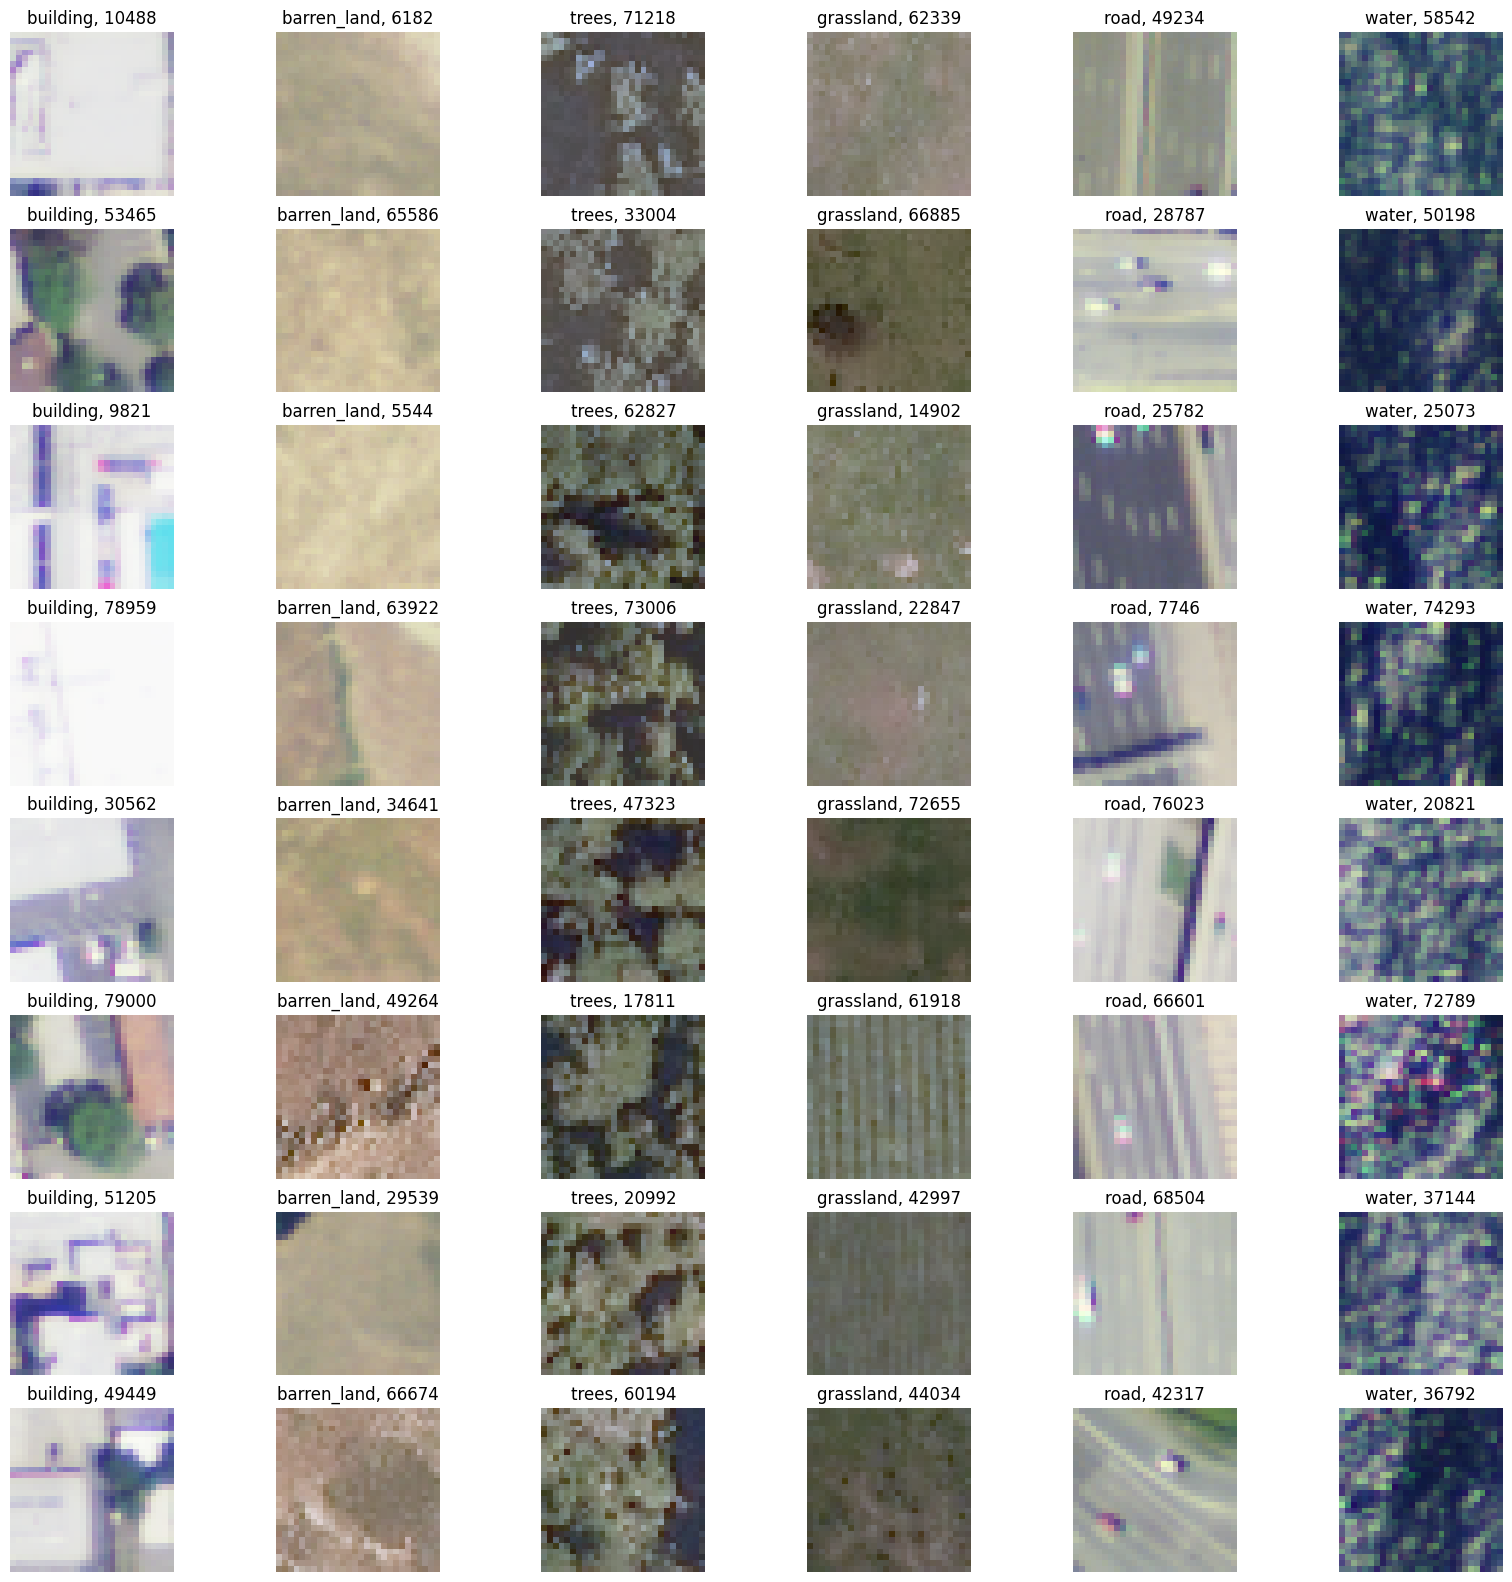

In [ ]:
num_classes = len(column_names)
num_samples = 8  # number of rows to plot
sample_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_samples from this index list - make sure to avoid duplicates
    sample_idx.append(np.random.choice(np.where(class_idx.values)[0], size=num_samples, replace=False).tolist())

fig, ax = plt.subplots(num_samples, num_classes, figsize=(20,20))
for i in range(num_samples):
    for j in range(num_classes):
        data_index = sample_idx[j][i]
        ax[i,j].set_title(f"{labels[j]}, {data_index}")
        ax[i,j].axis('off')
        data = np.reshape(landcover_df.iloc[data_index].values,(-1,28,28,4))
        ax[i,j].imshow(data[0,...,:3])

### Create the training and test datasets

The dataset is not balanced. Use ***num_train*** and ***num_test*** as a definite integer number.

Note: the maximum we tried is ***num_train*** = 2000 and ***num_test*** = 200. Beyond that for some classes, we did not find that many samples

In case you want all samples for training then use ***num_train*** = -1

In [ ]:
num_train = 1000 #replace with -1 if all samples need to be used for training
num_test = 100
train_idx = []
test_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_train and num_test values from this index list - make sure to avoid duplicates
    valid_indices = np.where(class_idx.values)[0]
    random_indices = np.random.permutation(valid_indices)
    test_idx.extend(random_indices[:num_test])
    train_idx.extend(random_indices[num_test:num_test+num_train if num_train != -1 else num_train])
print(f'number of train indices: {len(train_idx)}, number of test indices: {len(test_idx)}')


number of train indices: 6000, number of test indices: 600


In [ ]:
# Extract images and labels corresponding to the selected indices
train_X = landcover_df.iloc[train_idx]
train_y = labels_df.iloc[train_idx]
test_X = landcover_df.iloc[test_idx]
test_y = labels_df.iloc[test_idx]

# Calculate Normalization Parameter using Train Dataset

In [ ]:
train_X_reshape = train_X.values.reshape((-1,28,28,4))
mean_per_channels = np.mean(train_X_reshape,axis=(0,1,2)).astype(np.float32)
std_per_channels = np.std(train_X_reshape,axis=(0,1,2)).astype(np.float32)
mean_per_channels, std_per_channels

(array([132.88379, 132.858  , 130.02202, 120.78579], dtype=float32),
 array([55.80603 , 51.361763, 47.207165, 65.77481 ], dtype=float32))

## Define torch dataset

From here, we will make use of general workflow of PyTorch. First thing is to create a dataset. We are making use of mapped-style dataset. [Refer this page for more details](https://pytorch.org/docs/stable/data.html#map-style-datasets)

Important thing is to define the total length under dunder function *__len__* and data corresponding to the index under *__getitem__*

In [ ]:
class SAT6Dataset(Dataset):
  def __init__(self,data_df,label_df, normalization_parameter):
    super(SAT6Dataset,self).__init__()
    self.data_df = data_df
    self.label_df = label_df
    self.normalization = normalization_parameter

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self,idx):
    data = self.data_df.iloc[idx].values.reshape((28,28,4)).astype(np.float32)
    data = (data-self.normalization[0])/self.normalization[1]
    #data = data/255.0
    data = np.transpose(data,axes=(2,0,1))
    label = self.label_df.iloc[idx].values
    label_args = np.where(label==1)[0]

    return (data,label_args[0])

In [ ]:
# define two dataset one for train and other for test
sat6_train_dataset = SAT6Dataset(train_X,train_y,(mean_per_channels,std_per_channels))
sat6_test_dataset = SAT6Dataset(test_X,test_y,(mean_per_channels,std_per_channels))

Now, we will use **torch.nn.Module** to build our CNN model.

**Important points:**

*   To build modules in a list use **torch.nn.ModuleList()** instead of native list.

*   Define **forward** function to define the step-byt-by mathematical transformation




In [ ]:
class CNN(torch.nn.Module):
  def __init__(self,
               input_shape,
               num_conv_layers,
               channels_each_layer,
               kernel_size,
               mlp_dimension,
               activation_func,
               pooling,
               input_channels,
               num_classes,
               norm="batch_norm"):
    super(CNN,self).__init__()
    self.num_conv_layers = num_conv_layers
    self.channels_each_layer = channels_each_layer
    assert num_conv_layers == len(channels_each_layer),"Number of conv layers does not match with length of channels given"
    self.kernel_size = ([kernel_size] * num_conv_layers
                        if type(kernel_size) == int
                        else kernel_size)
    self.mlp_dimension = mlp_dimension
    if activation_func == 'relu':
      self.activation_func = torch.nn.ReLU()
    elif activation_func == 'tanh':
      self.activation_func = torch.nn.Tanh()
    else:
      assert False, "Currently only relu and tanh are provided in this code"

    if pooling == "max":
      self.pooling = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    else:
      self.pooling = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.input_channels = input_channels
    if norm=="batch_norm":
      self.batch_norms = [torch.nn.BatchNorm2d(channels_each_layer[i])
                          for i in range(len(self.kernel_size))]
    elif norm == "identity":
      self.batch_norms = [torch.nn.Identity() for i in range(len(self.kernel_size))]
    else:
      assert False,"only batch norm is provided in this code"

    self.conv_modules = torch.nn.ModuleList()

    for i in range(num_conv_layers):
      self.conv_modules.append(
          torch.nn.Conv2d(input_channels if i==0 else channels_each_layer[i-1],
                          channels_each_layer[i],
                          self.kernel_size[i],
                          stride=1,
                          padding='same',
                          bias=True))
      self.conv_modules.append(self.batch_norms[i])
      self.conv_modules.append(self.activation_func)
      self.conv_modules.append(self.pooling)
    dim_after_final_conv_layer = (input_shape[0]//2**num_conv_layers)*(
        input_shape[1]//2**num_conv_layers)*(
            channels_each_layer[-1])
    self.mlp_layer_modules = torch.nn.ModuleList()
    self.mlp_dimension = ([mlp_dimension]
                          if type(mlp_dimension) == int
                          else mlp_dimension)

    for i in range(len(self.mlp_dimension)):
      self.mlp_layer_modules.append(
          torch.nn.Linear((dim_after_final_conv_layer
                           if i==0
                           else self.mlp_dimension[i-1]),
                          self.mlp_dimension[i]))
      # Incase one want to try batch norm uncomment below line
      #self.mlp_layer_modules.append(torch.nn.BatchNorm1d(mlp_dimension[i]))
      self.mlp_layer_modules.append(self.activation_func)
    self.mlp_layer_modules.append(
        torch.nn.Linear(self.mlp_dimension[-1],num_classes))

  def forward(self,x):
    for module in self.conv_modules:
      x = module(x)
    x = x.flatten(1)
    for module in self.mlp_layer_modules:
      x = module(x)
    return x

In [ ]:
import torch.nn as nn
import torchvision.models as models

class ResNetWith4Channels(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load ResNet18 without pretrained weights
        self.resnet = models.resnet18(weights=None)

        # Replace first conv layer to accept 4 channels instead of 3
        self.resnet.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the final fully connected layer to match the number of classes
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.resnet(x)


Define the device (**GPU** if you use GPU as your runtime) else it will run on **CPU**)
Instatiation of the CNN model is also define in this cell

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet = ResNetWith4Channels(num_classes=6).to(device)


cpu


In [ ]:
# Overview of the model
print(resnet)

ResNetWith4Channels(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

Define training parameters


*   Optimizer : This reulates the rate of learning. USe wither adam or SGD. For other optimizers, feel free to add them.
*   Scheduler : It updates the learning rate during the training process. We have commented here out. PLease feel free to play with it.
*   Loss function: As it is a multi-class classification problem, CrossEntropy is a suitable loss function.



In [ ]:
optim = "adam"
optimizer = torch.optim.Adam(resnet.parameters(),lr=0.001) if optim == "adam" else torch.optim.SGD(resnet.parameters(),lr=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

Previously, we have defined dataset which takes an index as a parameter and provides data corresponding to the index. In such deep learning problems, we process them in a batch. DataLoader takes control of such requirements by defining the paraemter such as **batch_size** and **shuffle**.

**Note:**


*   In training, we want each time to have different samples in a batch. The ***shuffle*=True** ensures that. For validation, we do not required such shuffling, hence it is set to False
*   We used the whole length of test dataset as it is small. Incase of any issue with large number of test samples, feel free to decrease the number such as $256$



In [ ]:
train_dataloader = DataLoader(sat6_train_dataset,batch_size=256,shuffle=True,drop_last=True)
test_dataloader = DataLoader(sat6_test_dataset,len(sat6_test_dataset), shuffle=False)

# Training Routine
Define number of epochs for the training.


In [ ]:
num_epochs = 10
training_loss_per_epoch = []
validation_loss_per_epoch = []
acc_per_epoch = []

with tqdm(total=num_epochs) as pbar:
    for i in range(num_epochs):
        resnet.train()
        for train_data in train_dataloader:
            optimizer.zero_grad()
            data, labels = train_data
            data = data.to(device)
            labels = labels.to(device)

            preds = resnet(data)
            train_loss = loss_fn(preds, labels)
            train_loss.backward()
            optimizer.step()

        training_loss_per_epoch.append(train_loss.item())

        resnet.eval()
        pred_labels = []
        true_labels = []
        with torch.no_grad():
            for test_data in test_dataloader:
                data, labels = test_data
                data = data.to(device)
                labels = labels.to(device)

                preds = resnet(data)
                val_loss = loss_fn(preds, labels)
                pred_labels.extend(torch.argmax(preds, dim=1).cpu())
                true_labels.extend(labels.cpu())

        validation_loss_per_epoch.append(val_loss.item())
        acc = accuracy_score(true_labels, pred_labels)
        acc_per_epoch.append(acc)

        pbar.set_description(f"Epoch {i+1}/{num_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, acc={acc:.4f}")
        pbar.update(1)


Epoch 10/10: train_loss=0.0611, val_loss=0.7149, acc=0.8283: 100%|██████████| 10/10 [11:44<00:00, 70.41s/it]


The variables **training_loss_per_epoch**, **validation_loss_per_epoch**, and **acc_per_epoch** contains metrics after each epoch. Feel free to plot them to see how was the progress during training.

In [ ]:
# Write plot routine or use GenAI tool of colab.

In [ ]:
from sklearn.metrics import cohen_kappa_score

resnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)

        logits = resnet(data)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa Score: {kappa:.4f}")

Cohen's Kappa Score: 0.7940


<ipython-input-36-883f2f3c4b78>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


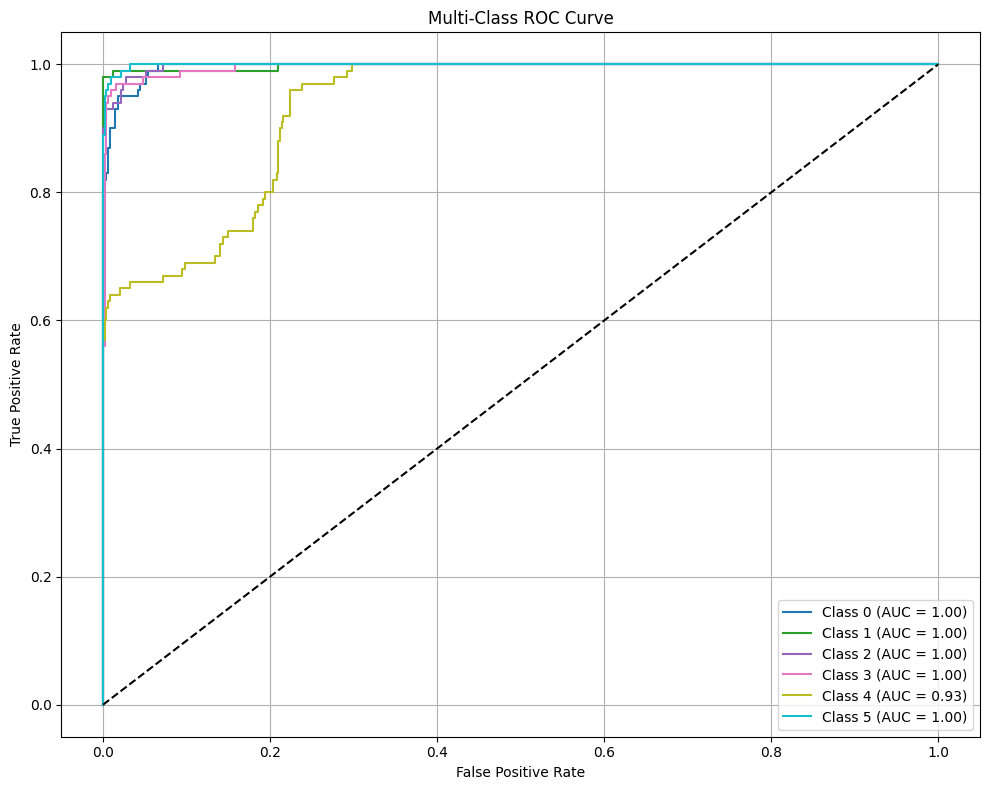

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

n_classes = 6

# Collect probabilities and labels
resnet.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for data, labels in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)

        logits = resnet(data)
        probs = torch.softmax(logits, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# One-hot encode labels for ROC
all_labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))

# Compute ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})', color=colors(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
